In [2]:
!pip install -q scikit-learn joblib matplotlib seaborn


In [3]:
import random
import re
import os
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)
np.random.seed(42)

In [4]:
# Cell 2 — synthetic dataset creation
def build_word_pools():

    pools = {}
    pools['en'] = [
        "the", "and", "is", "in", "to", "for", "with", "on", "this", "that",
        "data", "model", "language", "detect", "example", "test", "today", "new",
        "computer", "science", "project", "hello", "world", "thanks", "please"
    ]
    pools['es'] = [
        "el", "y", "es", "en", "para", "con", "sobre", "este", "esa",
        "datos", "modelo", "lenguaje", "detectar", "ejemplo", "prueba",
        "hoy", "nuevo", "computadora", "ciencia", "proyecto", "hola", "mundo", "gracias"
    ]
    pools['fr'] = [
        "le", "et", "est", "dans", "pour", "avec", "sur", "ce", "cette",
        "données", "modèle", "langue", "détecter", "exemple", "test",
        "aujourd'hui", "nouveau", "ordinateur", "science", "projet", "bonjour", "monde", "merci"
    ]
    pools['hi'] = [
        "यह", "और", "है", "में", "के", "के लिए", "के साथ", "पर", "यहाँ",
        "डेटा", "मॉडल", "भाषा", "पता", "उदाहरण", "परीक्षण",
        "आज", "नया", "कम्प्यूटर", "विज्ञान", "परियोजना", "नमस्ते", "धन्यवाद"
    ]
    pools['zh'] = [
        "这", "和", "是", "在", "为", "与", "上", "这个", "那个",
        "数据", "模型", "语言", "检测", "示例", "测试",
        "今天", "新的", "计算机", "科学", "项目", "你好", "世界", "谢谢"
    ]
    return pools

def random_sentence(pool, min_len=3, max_len=12):
    length = random.randint(min_len, max_len)
    words = [random.choice(pool) for _ in range(length)]

    return " ".join(words)

def add_noise(text, lang):

    r = random.random()
    if r < 0.1:
        text = text + "!"
    elif r < 0.2:
        text = text + "?"
    if random.random() < 0.15:
        text = text + " " + str(random.randint(1, 999))
    if lang == 'zh':
        text = text.replace(" ", "")
    return text

def generate_dataset(n_per_lang=3000):
    pools = build_word_pools()
    rows = []
    for lang, pool in pools.items():

        for i in range(n_per_lang):
            s = random_sentence(pool, min_len=3, max_len=12)

            if lang in ['en','es','fr'] and random.random() < 0.05:
                s = s.capitalize()
            s = add_noise(s, lang)
            rows.append((s, lang))
    df = pd.DataFrame(rows, columns=['text','lang'])

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

# Generate dataset (configurable)
n_per_lang = 3000
df = generate_dataset(n_per_lang=n_per_lang)
print("Dataset shape:", df.shape)
df.head(10)


Dataset shape: (15000, 2)


,text,lang
0,नया परीक्षण भाषा पता के के मॉडल उदाहरण आज पर ड...,hi
1,ce exemple monde détecter,fr
2,今天项目科学科学谢谢项目检测新的这这个与,zh
3,is to please is that example today model on co...,en
4,nuevo gracias nuevo,es
5,le et monde données monde sur,fr
6,hola para sobre modelo prueba computadora dete...,es
7,datos para ejemplo nuevo lenguaje en hoy cienc...,es
8,para modelo es con con modelo computadora datos,es
9,hello world science please and thanks today this,en


In [5]:
# Cell 3 — inspect distribution & examples
print(df['lang'].value_counts())
for lang in df['lang'].unique():
    print(f"\nSample ({lang}):")
    print(df[df['lang']==lang]['text'].sample(3, random_state=42).tolist())


lang
hi    3000
fr    3000
zh    3000
en    3000
es    3000
Name: count, dtype: int64

Sample (hi):
['कम्प्यूटर भाषा पता धन्यवाद मॉडल पता उदाहरण भाषा डेटा धन्यवाद नया 133', 'पर यह धन्यवाद यह मॉडल', 'पर आज कम्प्यूटर परियोजना डेटा यह विज्ञान नया']

Sample (fr):
['test ordinateur projet monde sur et sur ordinateur dans données test', "projet sur aujourd'hui sur détecter ce et dans langue bonjour avec", 'modèle sur exemple merci modèle détecter et']

Sample (zh):
['检测数据模型检测这个项目与', '世界模型语言那个模型在为检测!', '上上项目模型你好今天']

Sample (en):
['in project thanks hello the test?', 'For this hello model data language computer detect this that with', 'with example project thanks to world']

Sample (es):
['sobre para hola ciencia', 'en con ejemplo esa este nuevo esa hoy gracias el proyecto computadora', 'ejemplo esa ciencia es este detectar es ejemplo lenguaje prueba']


In [6]:
# Cell 4 — train/test split
X = df['text'].values
y = df['lang'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

print("Train:", len(X_train), "Test:", len(X_test))


Train: 12750 Test: 2250


In [7]:
# Cell 5 — build and train model
# Character n-grams are strong features for language ID
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,4), max_features=50000)
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga', C=1.0, n_jobs=-1)

pipe = make_pipeline(vectorizer, model)

print("Training model ... (this may take ~30-90s depending on dataset size & Colab instance)")
pipe.fit(X_train, y_train)
print("Training finished.")


Training model ... (this may take ~30-90s depending on dataset size & Colab instance)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training finished.


Test accuracy: 1.0000

Classification report:
              precision    recall  f1-score   support

          en     1.0000    1.0000    1.0000       450
          es     1.0000    1.0000    1.0000       450
          fr     1.0000    1.0000    1.0000       450
          hi     1.0000    1.0000    1.0000       450
          zh     1.0000    1.0000    1.0000       450

    accuracy                         1.0000      2250
   macro avg     1.0000    1.0000    1.0000      2250
weighted avg     1.0000    1.0000    1.0000      2250



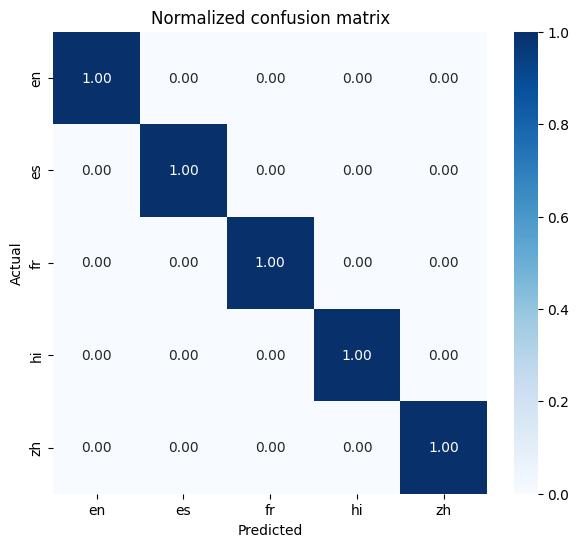

In [8]:
# Cell 6 — evaluation
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=['en','es','fr','hi','zh'])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=['en','es','fr','hi','zh'],
            yticklabels=['en','es','fr','hi','zh'], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized confusion matrix")
plt.show()


In [9]:
# Cell 7 — save model to Drive or local runtime
model_path = "lang_detector_pipeline.joblib"
joblib.dump(pipe, model_path)
print("Saved model to", model_path)



Saved model to lang_detector_pipeline.joblib


In [10]:
# Cell 8 — predictions on custom text
examples = [
    "This is an example sentence to test language detection.",
    "Este es un texto en español para comprobar.",
    "Ceci est un court texte en français.",
    "यह एक परीक्षण वाक्य है।",
    "这是一个中文的例子。"
]

preds = pipe.predict(examples)
probs = pipe.predict_proba(examples)

for txt, p, prob in zip(examples, preds, probs):
    top_idx = prob.argmax()
    top_score = prob[top_idx]
    print(f"Text: {txt}")
    print(f"Predicted: {p} (confidence: {top_score:.3f})\n")


Text: This is an example sentence to test language detection.
Predicted: en (confidence: 0.986)

Text: Este es un texto en español para comprobar.
Predicted: es (confidence: 0.976)

Text: Ceci est un court texte en français.
Predicted: fr (confidence: 0.575)

Text: यह एक परीक्षण वाक्य है।
Predicted: hi (confidence: 0.988)

Text: 这是一个中文的例子。
Predicted: zh (confidence: 0.991)



In [11]:
# Cell 9 — Interactive test loop
import joblib


model_path = "lang_detector_pipeline.joblib"
pipe = joblib.load(model_path)

print("✅ Language Detector Ready!\n")
print("Type any text in any language (English, Hindi, Spanish, French, Chinese).")
print("Type 'exit' or press Enter with no text to stop.\n")

while True:
    text = input("Enter text: ").strip()
    if text.lower() == "exit" or text == "":
        print("Exiting.")
        break
    pred = pipe.predict([text])[0]
    prob = pipe.predict_proba([text])[0].max()
    print(f"🗣 Detected Language: {pred}  (confidence: {prob:.3f})\n")


✅ Language Detector Ready!

Type any text in any language (English, Hindi, Spanish, French, Chinese).
Type 'exit' or press Enter with no text to stop.

Enter text: buen día
🗣 Detected Language: es  (confidence: 0.575)

Enter text: 谢谢
🗣 Detected Language: zh  (confidence: 0.985)

Enter text: धन्यवाद
🗣 Detected Language: hi  (confidence: 0.860)

Enter text: français
🗣 Detected Language: en  (confidence: 0.592)

Enter text: 
Exiting.
